In [1]:
import urllib2
import time
import lxml
import lxml.html

In [2]:
def getPageDoc(url):
    #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36'}
    headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.86 Safari/537.36'}
    request = urllib2.Request(url, headers=headers)  # 发送请求
    response = urllib2.urlopen(request)  # 获得响应
    time.sleep(1)
    content = response.read()  # 获取网页内容
    doc = lxml.html.fromstring(content)  # 可能是将网页以xml格式解析
    return doc

def getAndSavePic(pic_url, file_name):
    #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36'}
    headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.86 Safari/537.36'}
    request = urllib2.Request(url, headers=headers)  # 发送请求
    
    try:
        response = urllib2.urlopen(request)  # 获得响应
        time.sleep(0.5)
        img = response.read()
        # save image to disk
        imgFile = open(file_name,'wb')
        imgFile.write(img)
        imgFile.close()
    except Exception as t:
        raise t

### crawling images from https://www.zhidiy.com/jianzhi/page_*.html

In [3]:
def getPicURL(doc):
    '''extract picture urls from page https://www.zhidiy.com/jianzhi/page_*.html'''
    elements = doc.find_class('piclist_k')
    urls = []
    for e in elements:
        urls.append(e.getchildren()[0].xpath('a/img')[0].get('src'))
    return urls

for page_num in range(27):
    print page_num,
    page_url = 'https://www.zhidiy.com/jianzhi/page_'+str(page_num)+'.html'
    doc = getPageDoc(page_url)
    pic_urls = getPicURL(doc)
    for url in urls:
        file_name = url[url.rindex('/')+1:]
        getAndSavePic(url, file_name)
    print 'done'

### crawling images from baidu image

In [ ]:
import re
def getPicURL(doc):
    '''extract picture urls from page https://image.baidu.com/search_index?xx'''
    page = doc.text_content()
    reg =  re.compile('"thumbURL":"(.*?)"')
    urls = re.findall(reg, page)
    return urls

for page_num in range(2):
    print 'page_num', page_num,
    word = urllib2.quote('剪纸 春') # 剪纸 福 top 10pages; 剪纸 猪 top 2pages; 剪纸 春 top 2pages
    num_per_page = 60
    page_url = "https://image.baidu.com/search/flip?tn=baiduimage&ie=utf-8&word="+word+"&rn="+\
        "&pn="+str(num_per_page*page_num)+"&gsm=0&ct=&ic=0&lm=-1&width=0&height=0"
    doc = getPageDoc(page_url)
    pic_urls = getPicURL(doc)
    print '#pic', len(pic_urls),
    for pic_url in pic_urls:
        file_name = pic_url[pic_url.rindex('/')+1:]
        getAndSavePic(pic_url, './baidu_spring/'+file_name)
    print 'done'
print 'ALL DONE'

### save resource to baidu yunpan
from https://blog.csdn.net/BF02jgtRS00XKtCx/article/details/78852786
https://www.jianshu.com/p/56f0c07e0ecb

In [ ]:
import re
href_urls = []
base_url = 'http://sopanba.com'
for page_num in xrange(1,9):
    doc = getPageDoc(base_url+'/u/bd-589977644/'+str(page_num))
    t = doc.xpath('/html/body/div[6]/div/table')[0].getchildren()
    print '#page', page_num, '#urls', len(t)-1
    for child in t[1:]:
        href_url =  base_url + child.getchildren()[0].getchildren()[0].get('href')
        href_doc = getPageDoc(href_url)
        href_url = href_doc.xpath('/html/body/div[4]/div/center/a')[0].get('href')
        href_doc = getPageDoc(href_url)
        # get real url
        print href_url,
        href_url = href_doc.xpath('/html/head')[0].getchildren()[0].get('content')
        pattern = 'URL=\'(.*?)\?'
        srch_ob = re.search(pattern, href_url)
        href_url = srch_ob.group(1)
        print href_url
        href_urls.append(href_url)
        time.sleep(1)

In [ ]:
# -*- coding:utf-8 -*-
import requests
import json
import time
import re
from selenium import webdriver
#from wechat_robot.business import proxy_mine

class BaiduYunTransfer:

    headers = None
    bdstoken = None
    #pro = proxy_mine.Proxy()

    def __init__(self,bduss,stoken,bdstoken):
        self.bdstoken = bdstoken
        self.headers = {
            'Accept': '*/*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'zh-CN,zh;q=0.8',
            'Connection': 'keep-alive',
            'Content-Length': '161',
            'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
            'Cookie': 'BDUSS=%s;STOKEN=%s;' % (bduss, stoken),
            'Host': 'pan.baidu.com',
            'Origin': 'https://pan.baidu.com',
            'Referer': 'https://pan.baidu.com/s/1dFKSuRn?errno=0&errmsg=Auth%20Login%20Sucess&&bduss=&ssnerror=0',
            'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36",
            #self.pro.get_user_agent(),
            'X-Requested-With': 'XMLHttpRequest',
        }

    def transfer(self,share_id,uk,filelist_str,path_t_save):
        # 通用参数
        ondup = "newcopy"
        async = "1"
        channel = "chunlei"
        clienttype = "0"
        web = "1"
        app_id = "250528"
        logid = "你的logid"

        url_trans = "https://pan.baidu.com/share/transfer?shareid=%s" \
                    "&from=%s" \
                    "&ondup=%s" \
                    "&async=%s" \
                    "&bdstoken=%s" \
                    "&channel=%s" \
                    "&clienttype=%s" \
                    "&web=%s" \
                    "&app_id=%s" \
                    "&logid=%s" % (share_id, uk, ondup, async, self.bdstoken, channel, clienttype, web, app_id, logid)

        form_data = {
            'fsidlist': filelist_str,
            'path': path_t_save,
        }

        #proxies = {'http': self.pro.get_ip(0, 30, u'国内')}

        response = requests.post(url_trans, data=form_data, headers=self.headers)#proxies = proxies,
        print response.content

        jsob = json.loads(response.content)

        if "errno" in jsob:
            return jsob["errno"]
        else:
            return None

    def get_file_info(self,url):
        driver = webdriver.Chrome()
        print u"初始化代理..."
        #driver = self.pro.give_proxy_driver(driver)
        print u"尝试打开"
        driver.get(url)
        time.sleep(1)
        print u"正式打开链接"
        driver.get(url)
        print u"成功获取并加载页面"
        
        script_list = driver.find_elements_by_xpath("//body/script")
        innerHTML = script_list[-1].get_attribute("innerHTML")

        pattern = '"fs_id":(.*?),[\s\S]*"uk":(.*?),[\s\S]*"shareid":(.*?),[\s\S]*'  # [\s\S]*可以匹配包括换行的所有字符,\s表示空格，\S表示非空格字符

        srch_ob = re.search(pattern, innerHTML)

        fsidlist = '[%s]'%srch_ob.group(1)
        share_uk = srch_ob.group(2)
        share_id = srch_ob.group(3)

        return share_id, share_uk, fsidlist

    def transfer_url(self,url_bdy,path_t_save):
        try:
            print u"发送连接请求..."
            share_id, share_uk, fsidlist = self.get_file_info(url_bdy)
        except:
            print u"链接失效了，没有获取到fileinfo..."
        else:
            error_code = self.transfer(share_id, share_uk, fsidlist, path_t_save)
            if error_code == 0:
                print u"转存成功！"
            else:
                print u"转存失败了，错误代码：" + str(error_code)

In [ ]:
bduss = '你的BDUSS' 
stoken = '你的STOKEN'
bdstoken = "你的bdstoken
bdy_trans = BaiduYunTransfer(bduss,stoken,bdstoken)

#url_src = "https://pan.baidu.com/s/1fE4W2?fid=59696782420458"
path = u"/zhiyi"
for url_src in href_urls:
    bdy_trans.transfer_url(url_src,path)

### preprocessing image: crop and resize

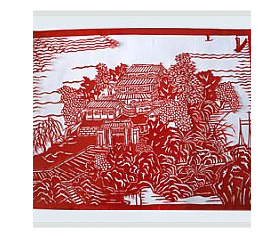

In [1]:
import matplotlib.pyplot as plt # plt 用于显示图片
%matplotlib inline
import matplotlib.image as mpimg # mpimg 用于读取图片

def plt_im(file_name):
    im_data = mpimg.imread(file_name) # img To array
    plt.imshow(im_data) # 显示图片, 可选参数cmap=['hot'|'Greys_r']
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
plt_im('./dataset/2142_1714200213_224.jpg')

In [ ]:
import os
src_dir_path = './dataset' # other dirs: '/baidu/spring/', './baidu_pig', './baidu_fu', './dataset'
dst_dir_path = './resized_dataset'
dst_height, dst_width = 224, 224
for file_name in os.listdir(src_dir_path):
    src_path = os.path.join(src_dir_path, file_name)
#     plt_im(src_path)
    src = mpimg.imread(src_path)
    shape = src.shape
    if len(src.shape)==3 and shape[0]>=dst_width and shape[1]>=dst_height:
        crop_size = min(shape[0], shape[1])
        width_start, width_end = (shape[1]-crop_size)/2, shape[1]-(shape[1]-crop_size)/2
        height_start, height_end = (shape[0]-crop_size)/2, shape[0]-(shape[0]-crop_size)/2
        dst = src[height_start:height_end, width_start:width_end, :]
        dst = scipy.misc.imresize(dst, (dst_height, dst_width))
        if dst.shape[:2]==(dst_height, dst_width):
            try:
                scipy.misc.imsave(os.path.join(dst_dir_path, file_name), dst)
            except Exception as t:
                os.remove(os.path.join(dst_dir_path, file_name))
                print src_path, t
        else:
            print dst.shape

### 

### XDoG for sketch filtering
source from https://blog.csdn.net/qq_27879381/article/details/72718135

In [ ]:
from PIL import Image, ImageEnhance
from pylab import *
#import numpy as np
from scipy.ndimage import filters
#from skimage import io
import glob, os

in_dir = './resized'
out_dir = in_dir + '_gamma0.98'
if not os.path.exists(out_dir): os.mkdir(out_dir)

for files1 in glob.glob(in_dir + '/*'):
    filepath, filename = os.path.split(files1)

    Gamma = 0.98
    Phi = 200
    Epsilon = 0.1
    k = 2.5
    Sigma = 1.5

    im = Image.open(files1).convert('L')
    im = array(ImageEnhance.Sharpness(im).enhance(3.0))
    im2 = filters.gaussian_filter(im, Sigma)
    im3 = filters.gaussian_filter(im, Sigma* k)
    differencedIm2 = im2 - (Gamma * im3)
    (x, y) = shape(im2)
    for i in range(x):
        for j in range(y):
            if differencedIm2[i, j] < Epsilon:
                differencedIm2[i, j] = 1
            else:
                differencedIm2[i, j] = 250 + tanh(Phi * (differencedIm2[i, j]))


    gray_pic=differencedIm2.astype(np.uint8)
    final_img = Image.fromarray( gray_pic)
    final_img.save(os.path.join(out_dir, filename))
